<a href="https://colab.research.google.com/github/yopi1838/CR-Jupyter-Exercise/blob/master/Truss_elastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Title
### Truss (Linear and Elastic)
**Units:** Newtons (N), meters (m), seconds (s)

In this example, we will build and analyze a simple 2D truss element using [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/) and discuss how you might visualize it with **opsvis**.

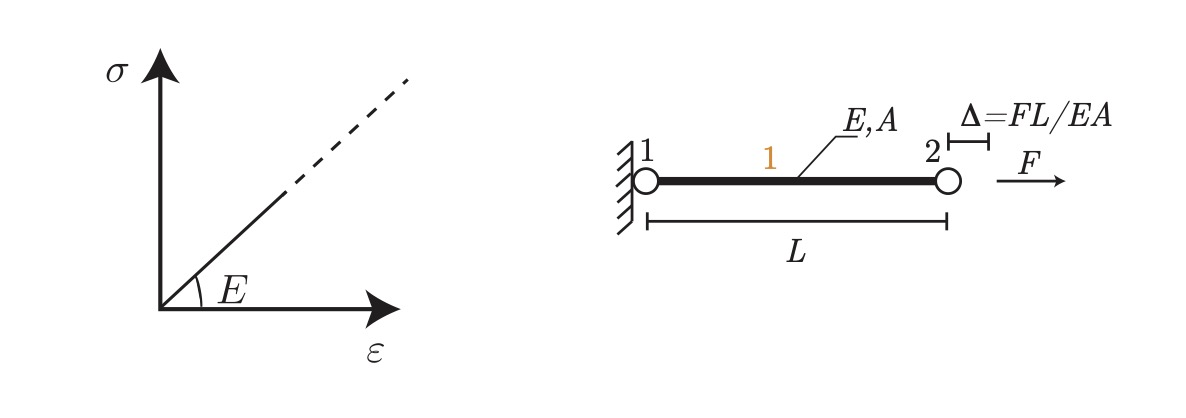

In [1]:
!pip install openseespy
!pip install opsvis

# Units: N, m, sec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 2.4 MB/s eta 0:00:00


In [2]:
import openseespy.opensees as ops
import opsvis as opsv
import os
import matplotlib.pyplot as plt

In [3]:
#%% INITIALIZE
# Remove existing model:
ops.wipe() #important to clean the model everytime you start the analysis
# Create data directory:
DataDir = r'Output'
if not os.path.exists(DataDir):
    os.makedirs(DataDir)

In [4]:
print("Truss (Linear and Elastic) example - Starting...")

Truss (Linear and Elastic) example - Starting...


# 2. Inputs
We define the key input parameters for the truss model:
- **L** : length of the truss element
- **B** , **H** : cross-sectional dimensions
- **E** : Elastic modulus
- **A** : Cross-sectional area (computed)
- **F** : Horizontal force applied at the free node

Additionally, we create an **Output** folder to store any recorded results.


In [5]:
# --- INITIALIZE & INPUTS ---
# Define length:
L = 3.2 #m
# Define cross-section:
B = 0.05 #m
H = 0.07 #m
# Define elastic modulus:
E = 2.1e10  # N/m^2
# Compute cross-sectional area:
A = B * H #m^2
# Set the horizontal force:
F = 10.0  # N

print("Inputs:")
print(f" Length L = {L} m")
print(f" B x H = {B} m x {H} m")
print(f" E = {E} N/m^2")
print(f" A = {A} m^2")
print(f" F = {F} N")

Inputs:
 Length L = 3.2 m
 B x H = 0.05 m x 0.07 m
 E = 21000000000.0 N/m^2
 A = 0.0035000000000000005 m^2
 F = 10.0 N


# 3. Model
Create and define the 2D truss model:
- **ops.model("Basic", ndm=2, ndf=2)** specifies 2 dimensions, 2 degrees of freedom per node.
- We create two nodes (Node 1 at `(0,0)`, Node 2 at `(L, 0)`).
- **ops.fix(...)** sets boundary conditions.
- **ops.uniaxialMaterial(...)** defines the elastic material.
- **ops.element("Truss")** connects Node 1 and Node 2.

In [6]:
# --- MODEL ---
# Create ModelBuilder with 2 dimensions and 2 DOF/node
ops.model("Basic", "-ndm", 2, "-ndf", 2)

# Create nodes:
ops.node(1, 0.0, 0.0)
ops.node(2, L, 0.0)

# Boundary conditions:
# Node 1 is fully fixed in X and Y directions
ops.fix(1, 1, 1)
# Node 2 is restrained in vertical DOF only, free in X direction
ops.fix(2, 0, 1)

# Define an elastic uniaxial material:
ops.uniaxialMaterial("Elastic", 1, E)

# Define a Truss element:
ops.element("Truss", 1, 1, 2, A, 1) # (ElemType, ElemTag, nodeTag1, nodeTag2, Area, MaterialTag)

print("Model defined.")

Model defined.


# 4. Loads
Next, we apply a single horizontal load at Node 2:
- A **Linear** TimeSeries.
- A **Plain** load pattern referencing that TimeSeries.
- The load is in the X direction with magnitude **F**.

In [7]:
# --- LOADS ---
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
# Apply horizontal load F on Node 2
ops.load(2, F, 0.0) #F coordinates follows the global coordinates

print("Loads applied.")

Loads applied.


# 5. Recorder
Define recorders to capture:
- Displacement of Node 2 (in both X and Y DOFs)
- Reaction forces at Node 1
- Element forces in the truss

These outputs will be saved in the `Output` folder.


In [8]:
# --- RECORDER ---
ops.recorder("Node", "-file", f"{DataDir}/Dfree.out", "-time", "-closeOnWrite",
             "-node", 2, "-dof", 1, 2, "disp")
ops.recorder("Node", "-file", f"{DataDir}/RBase.out", "-time", "-closeOnWrite",
             "-node", 1, "-dof", 1, 2, "reaction")
ops.recorder("Element", "-file", f"{DataDir}/eleGlobal.out", "-time", "-closeOnWrite",
             "-ele", 1, "forces")

print("Recorders defined. Files will be saved to the Output folder.")

Recorders defined. Files will be saved to the Output folder.


# 6. Analysis
We set up and perform a static analysis with one load step:
- **ops.constraints("Plain")** : handles boundary conditions.
- **ops.numberer("Plain")** : assigns equation numbers.
- **ops.system("BandSPD")** : solves the system of equations.
- **ops.algorithm("Linear")** : linear solution algorithm.
- **ops.integrator("LoadControl", 1)** : single load step.
- **ops.analysis("Static")** : static structural analysis.

Finally, **ops.analyze(1)** executes the analysis.

In [19]:
# --- ANALYSIS ---
ops.constraints("Plain")
ops.numberer("Plain")
ops.system("BandSPD")
ops.algorithm("Linear")
ops.integrator("LoadControl", 1)
ops.analysis("Static")

# Perform static analysis:
ops.analyze(10)

print("Analysis completed.")

Analysis completed.


WARNING can't set handler after analysis is created


# 7. Screen Print
Compare the theoretical displacement with the one computed by OpenSeesPy:

For a straight axial bar, the **analytical** displacement is:
\[
  \delta = \frac{F\,L}{E\,A}.
\]

We then:
- Print the **expected** displacement.
- Print the **OpenSees** displacement from `ops.nodeDisp(2)`.

Finally, we sign off with "prof Lu is my favorite!"


In [24]:
# --- SCREEN PRINT ---
# Compare with known displacement for an axial truss
disp_theory = (F * L) / (E * A)
disp_opensees = ops.nodeDisp(2)[0]  # x-direction displacement of node 2

print("\n*** Results ***")
print(f"Analytical displacement: {disp_theory} m")
print(f"OpenSees displacement:   {disp_opensees} m")


*** Results ***
Analytical displacement: 5.65986394557823e-06 m
OpenSees displacement:   5.790476190476192e-06 m


In [11]:
# Print the model
ops.printModel()

Current Domain Information
	Current Time: 1
	Committed Time: 1
NODE DATA: NumNodes: 2

numComponents: 2

 Node: 1
	Coordinates  : 0 0 
	Disps: 0 0 
	Velocities   : 0 0 
	 unbalanced Load: 0 0 
	 reaction: -10 0 
	ID : -1 -1 


 Node: 2
	Coordinates  : 3.2 0 
	Disps: 4.35374e-07 0 
	Velocities   : 0 0 
	 unbalanced Load: 10 0 
	 reaction: 0 0 
	ID : 0 -1 

ELEMENT DATA: NumEle: 1

numComponents: 1
Element: 1 type: Truss  iNode: 1 jNode: 2 Area: 0.0035 Mass/Length: 0 cMass: 0 
	 strain: 1.36054e-07 axial load: 10 
	 unbalanced load: -10 -0 10 0 
 	 Material: 

SP_Constraints: numConstraints: 3

numComponents: 3
SP_Constraint: 0	 Node: 1 DOF: 1 ref value: 0 current value: 0 initial value: 0
SP_Constraint: 1	 Node: 1 DOF: 2 ref value: 0 current value: 0 initial value: 0
SP_Constraint: 2	 Node: 2 DOF: 2 ref value: 0 current value: 0 initial value: 0

Pressure_Constraints: numConstraints: 0

numComponents: 0

MP_Constraints: numConstraints: 0

numComponents: 0

LOAD PATTERNS: numPatterns: 1


Text(0.5, 1.0, 'Axial forces, max = -10.00, min = -10.00')

<Figure size 640x480 with 0 Axes>

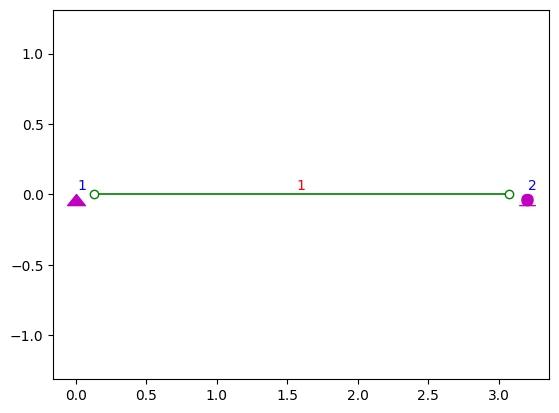

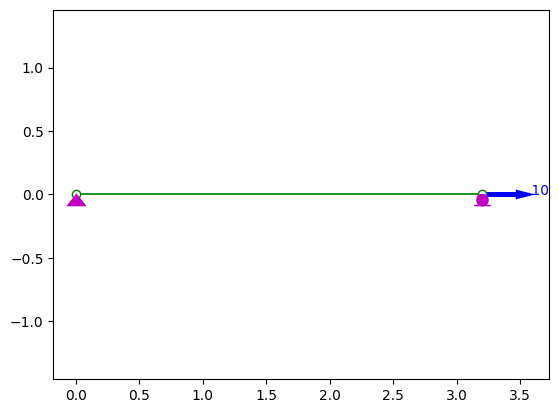

<Figure size 640x480 with 0 Axes>

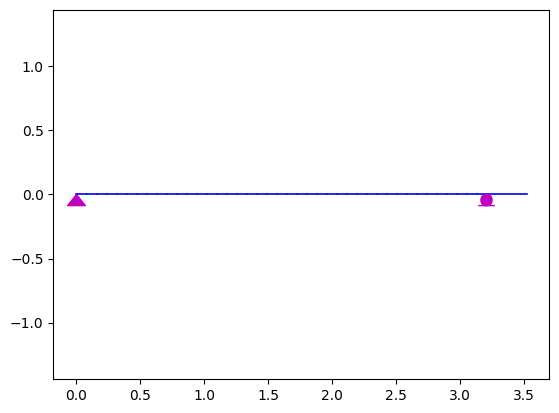

<Figure size 640x480 with 0 Axes>

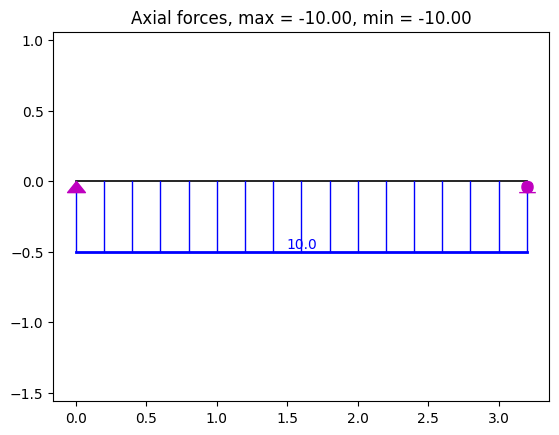

In [12]:
# 0. plot model with tag lebels
fig = plt.figure()
opsv.plot_model()

# 1. plot supports and loads
opsv.plot_load()

# 2. plot deformed model
plt.figure()

sfac = 1000.
opsv.plot_defo(sfac)

# 3. plot N force diagrams
sfacN = 1/20

plt.figure()
minVal, maxVal, _ = opsv.section_force_diagram_2d('N', sfacN)
plt.title(f'Axial forces, max = {maxVal:.2f}, min = {minVal:.2f}')

In [ ]:
print("\nprof Di Trapani is my favorite in the world!")